In [1]:
import pandas as pd
import numpy as np
import cv2
from datetime import datetime, timedelta
import heapq


In [2]:
#dijkstra - big map with diagonals adjusted for diaonals length

def dijkstra_map (matrix, start, end, verbose=1):
    if verbose>0: 
        print(f'Leg start - {start}, route end: {end}')
    m, n = matrix.shape
    # Create a priority queue to store (cost, position) tuples
    pq = [(matrix[start], start)]
    # Create a distance matrix to store the minimum time to reach each cell
    dist = np.full((m, n), np.inf)
    dist[start] = matrix[start]
    # Create a predecessor matrix to store the path
    predecessor = np.full((m, n), None, dtype=object)
    # Directions for moving to adjacent cells (right, down, left, up, and diagonals)
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]
    
    while pq:
        current_cost, (x, y) = heapq.heappop(pq)
        # If we have reached the destination, construct the path
        if (x, y) == end:
            path = []
            while (x is not None)&(y is not None):
                path.append((x, y))
                
                if predecessor[x, y] is not None:
                    x, y = predecessor[x, y]
                else:
                    x, y = None,None
                
            path.reverse()
            return current_cost, path
        
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < m and 0 <= ny < n:
                new_cost = current_cost + (matrix[nx, ny] + matrix[x, y])*(np.sqrt(dx**2+dy**2))/2
                if new_cost < dist[nx, ny]:
                    dist[nx, ny] = new_cost
                    predecessor[nx, ny] = (x, y)
                    heapq.heappush(pq, (new_cost, (nx, ny)))
    
    # If there's no valid path (which shouldn't happen in a grid), return inf
    return np.inf, []

def find_min_idx(x):
    k = x.argmin()
    ncol = x.shape[1]
    return k//ncol, k%ncol

def find_point_loc(point_lat, point_lon,lat, lon):
    coord = point_lon//1.*10000 + point_lat 
    a = np.multiply(lon,10000)
    coded = np.add(a, lat)
    dist = np.subtract(coded, coord)
    dist = np.where(dist<0,10,dist)
    return find_min_idx(dist)

def read_schedule():
    schedule = pd.read_excel('vessel_schedule.xlsx')
    return schedule

# функция пересчета скоростей в зависимости от ледовой обстановки и наличия ледокола
def update_speed (df_map, df_vessel, vessel_name, ice_breaker = 0):
    vessel_data = df_vessel[df_vessel['Название судна']==vessel_name].reset_index()
    #print(vessel_data)
    max_speed = vessel_data.loc[0, 'Скорость, узлы (по чистой воде)']
    #print(max_speed)
    coeff_20_22 = vessel_data.loc[0, '20-22']
    coeff_20_22_w_breaker = vessel_data.loc[0, '20 ice breaker']
    coeff_15_19 = vessel_data.loc[0, '19-15']
    coeff_15_19_w_breaker = vessel_data.loc[0, '15 ice breaker']
    coeff_10_14 = vessel_data.loc[0, '14-10']
    coeff_10_14_w_breaker = vessel_data.loc[0, '10 ice breaker']
    coeff_0_10 = vessel_data.loc[0, '0-10']
    if ice_breaker ==0:
        
        df_map = np.where(df_map<=0, 0.000001, df_map)
        df_map = np.where((df_map<=10)&(df_map>0), coeff_0_10, df_map)
        df_map = np.where(df_map>=19.5, coeff_20_22, df_map)
        df_map = np.where((df_map>=14.5)&(df_map<19.5), coeff_15_19, df_map)
        df_map = np.where((df_map>=10)&(df_map<14.5), coeff_10_14, df_map)
        
    elif ice_breaker ==1:
        df_map = np.where(df_map<=0, 0.000001, df_map)
        df_map = np.where((df_map<=10)&(df_map>0), coeff_0_10, df_map)
        df_map = np.where(df_map>=19.5, coeff_20_22_w_breaker, df_map)
        df_map = np.where((df_map>=14.5)&(df_map<19.5), coeff_15_19_w_breaker, df_map)
        df_map = np.where((df_map>=10)&(df_map<14.5), coeff_10_14_w_breaker, df_map)
               
    return df_map*max_speed

#creates a matrix with all the vessels positions and timings at SMP
def create_sevmorput_matrix(schedule, point_coord):
    
    tmp = schedule.iloc[:,:6]#[schedule['Ледовый класс']!='Arc 9']
    tmp.loc[:,'Route_ID'] = [f'{row[0]}_{row[1]}-{row[2]}_{row[3]}' for row in zip(tmp['Название судна'],tmp['Пункт начала плавания'], tmp['Пункт окончания плавания'],tmp['Дата начала плавания'])]
    tmp.loc[tmp['Ледовый класс']=='Arc 9',['Route_ID']] = ''
    sevmorput_matrix = tmp
    
    for i in range(len(sevmorput_matrix)):
        if sevmorput_matrix.loc[i, 'Ледовый класс']!='Arc 9':
            sevmorput_matrix.loc[i, 'Start_point_coord_X'] = (point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт начала плавания'].lower(), 'point_coord'].iloc[0][0])
            sevmorput_matrix.loc[i, 'Start_point_coord_Y'] = int(point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт начала плавания'].lower(), 'point_coord'].iloc[0][1])
            sevmorput_matrix.loc[i, 'End_point_coord_X'] = int(point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт окончания плавания'].lower(), 'point_coord'].iloc[0][0])
            sevmorput_matrix.loc[i, 'End_point_coord_Y'] = int(point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт окончания плавания'].lower(), 'point_coord'].iloc[0][1])

        else:
            sevmorput_matrix.loc[i, 'Start_point_coord_X'] = int(point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт начала плавания'].lower(), 'point_coord'].iloc[0][0])
            sevmorput_matrix.loc[i, 'Start_point_coord_Y'] = int(point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт начала плавания'].lower(), 'point_coord'].iloc[0][1])
            sevmorput_matrix.loc[i, 'End_point_coord_X'] = int(point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт начала плавания'].lower(), 'point_coord'].iloc[0][0])
            sevmorput_matrix.loc[i, 'End_point_coord_Y'] = int(point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт начала плавания'].lower(), 'point_coord'].iloc[0][1])

        sevmorput_matrix.loc[i, 'Path'] = None
        sevmorput_matrix.loc[i, 'Start_time_actual'] = None
        sevmorput_matrix.loc[i, 'Time_enroute_total'] = 0
        
        direction = (sevmorput_matrix.loc[i,'Start_point_coord_X'] + sevmorput_matrix.loc[i,'Start_point_coord_Y']) - (sevmorput_matrix.loc[i,'End_point_coord_X'] + sevmorput_matrix.loc[i,'End_point_coord_Y'])
        if direction> 0:
            sevmorput_matrix.loc[i, 'Direction'] = 'W'
        else:
            sevmorput_matrix.loc[i, 'Direction'] = 'E'
    
    sevmorput_matrix['Start_point_coord_X'] = sevmorput_matrix['Start_point_coord_X'].astype(int)
    sevmorput_matrix['Start_point_coord_Y'] = sevmorput_matrix['Start_point_coord_Y'].astype(int)
    sevmorput_matrix['End_point_coord_X'] = sevmorput_matrix['End_point_coord_X'].astype(int)
    sevmorput_matrix['End_point_coord_Y'] = sevmorput_matrix['End_point_coord_Y'].astype(int)
    
    
    return sevmorput_matrix
def create_vessels_dbase(sevmorput_matrix, point_coord):
    vessel_dbase = []
    for i in range(len(sevmorput_matrix)):
        if sevmorput_matrix.loc[i, 'Ледовый класс']!='Arc 9':
            #db_dict = 'vessel_route_data_'+str(i)
            db_dict = {}
            db_dict['Название судна'] = sevmorput_matrix.loc[i, 'Название судна']
            db_dict['Дата начала плавания'] = sevmorput_matrix.loc[i, 'Дата начала плавания']
            db_dict['Пункт начала плавания'] = sevmorput_matrix.loc[i, 'Пункт начала плавания']
            db_dict['Пункт окончания плавания'] = sevmorput_matrix.loc[i, 'Пункт окончания плавания']
            db_dict['Route_ID'] = sevmorput_matrix.loc[i, 'Route_ID']
            db_dict['Direction'] = sevmorput_matrix.loc[i, 'Direction']
            db_dict['Vessel_speed_data'] = vessel_speed[vessel_speed['Название судна']==sevmorput_matrix.loc[i, 'Название судна']]
            db_dict['Ледовый класс'] = sevmorput_matrix.loc[i, 'Ледовый класс']
            db_dict['Start_point_coord'] = point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт начала плавания'].lower(), 'point_coord'].iloc[0]
            db_dict['End_point_coord'] = point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт окончания плавания'].lower(), 'point_coord'].iloc[0]
            db_dict['Time_enroute_total'] = 0
            db_dict['Current_point_coord'] = db_dict['Start_point_coord']
            db_dict['Convoy'] = False
            db_dict['Current_date'] = datetime.strftime(sevmorput_matrix.loc[i, 'Дата начала плавания'], '%Y-%m-%d')
            db_dict['Пройденный путь'] = []
            db_dict['Планируемый путь'] = []
            db_dict['Key_points'] = []
            db_dict['Key_point_arrival_times'] = []
            db_dict['Updated_time_map_ib'] = None
            db_dict['Updated_time_map_no_ib'] = None
            db_dict['Started'] = False
            db_dict['Completed'] = False
            db_dict['Vessel_speed_data_convoy'] = None
            db_dict['Прибытие в пункт окончания плавания'] = None
            db_dict['Overtime'] = 0
           
        vessel_dbase.append(db_dict)
    return vessel_dbase

def create_ice_breaker_dbase(sevmorput_matrix, point_coord):
    sevmorput_matrix = sevmorput_matrix
    vessel_dbase = []
    sevmorput_matrix = sevmorput_matrix[sevmorput_matrix['Ледовый класс']=='Arc 9']
    sevmorput_matrix = sevmorput_matrix.reset_index()
    #print(sevmorput_matrix)
    for i in range(len(sevmorput_matrix)):
        if sevmorput_matrix.loc[i, 'Ледовый класс']=='Arc 9':
            db_dict = {}
            db_dict['Название судна'] = sevmorput_matrix.loc[i, 'Название судна']
            db_dict['Дата начала плавания'] = sevmorput_matrix.loc[i, 'Дата начала плавания']
            db_dict['Пункт начала плавания'] = sevmorput_matrix.loc[i, 'Пункт начала плавания']
            db_dict['Пункт окончания плавания'] = sevmorput_matrix.loc[i, 'Пункт окончания плавания']
            db_dict['Route_ID'] = None
            db_dict['Direction'] = None#sevmorput_matrix.loc[i, 'Direction']
            db_dict['Vessel_speed_data'] = breakers_speed[breakers_speed['Название судна']==sevmorput_matrix.loc[i, 'Название судна']]
            db_dict['Ледовый класс'] = sevmorput_matrix.loc[i, 'Ледовый класс']
            db_dict['Start_point_coord'] = point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт начала плавания'].lower(), 'point_coord'].iloc[0]
            db_dict['End_point_coord'] = None#point_coord.loc[point_coord['point_name'] == sevmorput_matrix.loc[i, 'Пункт окончания плавания'].lower(), 'point_coord'].iloc[0]
            db_dict['Time_enroute_total'] = 0
            db_dict['Current_point_coord'] = db_dict['Start_point_coord']
            db_dict['Convoy'] = False
            db_dict['Current_date'] = datetime.strftime(sevmorput_matrix.loc[i, 'Дата начала плавания'], '%Y-%m-%d')
            db_dict['Пройденный путь'] = []
            db_dict['Планируемый путь'] = []
            db_dict['Key_points'] = []
            db_dict['Key_point_arrival_times'] = []
            db_dict['Updated_time_map'] = None
            db_dict['Overtime'] = 0
            db_dict['Started'] = False
            db_dict['Completed'] = False
            db_dict['Vessel_speed_data_convoy'] = None
           
        vessel_dbase.append(db_dict)
    return vessel_dbase


In [3]:
#update df_vessel with speed and other data
def vessel_data(df, df_speed):
    for i in range(len(df_vessel)):
        ice_class = df_vessel.loc[i,'Ледовый класс']
        df.iloc[i,3:10] = df_speed[df_speed['Ледовый класс']==ice_class].iloc[0,1:8]
    return df



In [4]:
def daily_move(path, current_point_index, updated_time_map, overtime=0):
    counter = current_point_index # checks the index of current point in the path
    matrix = updated_time_map
    if counter>=len(path):
        print(f'Vessel either reached destination or something went wrong. Counter = {counter}, total path length = {len(path)} ')
        overtime = 0
        return path[-1], counter, overtime
    else:
        x,y = zip(*path)
        current_cost = overtime
        new_cost = 0
        

        while (current_cost<=24)&(counter<len(path)-1):
            #print(path[counter])
            dx = x[counter+1]- x[counter]
            dy = y[counter+1] - y[counter]
            new_cost = current_cost + (matrix[x[counter], y[counter]] + matrix[x[counter+1], y[counter+1]])*(np.sqrt(dx**2+dy**2))/2
            current_cost = new_cost
            #print(current_cost)
            counter+=1
        #print(current_cost)
        overtime = current_cost-24
        if overtime<0:
            print(f'______________________Vessel has arrived to the destination at some {int(24+overtime)} hh')
            
        #print(overtime)
        return path[counter], counter, overtime

In [5]:
#create timings for each square at the map - map with speed is the source
def update_map_time(df, grid_size=25):
    return np.divide(grid_size,df)

In [6]:
def add_time_to_dates(start_time, add_hours):
    # Parse the start date string into a datetime object
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d %H:%M")
    end_date = start_date+timedelta(hours=add_hours)
    return datetime.strftime(end_date, "%Y-%m-%d %H:%M")

In [7]:
def add_day_to_date(date):
    # Parse the start date string into a datetime object
    date = datetime.strptime(date, "%Y-%m-%d")
    date = date+timedelta(hours=24)
    new_date = datetime.strftime(date, "%Y-%m-%d")
    return new_date


In [8]:
def find_ice_breaker_meet_points(est_arrival_time_key_points_i, key_points_coord_i):
    ib_poins_list = []
    timings = []
    for i in range(1,len(key_points_coord_i)-1,2):
        ib_poins_list.append(key_points_coord_i[i])
        timings.append(sum(est_arrival_time_key_points_i[:i]))
   
    return ib_poins_list, timings

#ib_points_list, timings = find_ice_breaker_meet_points(est_arrival_time_key_points[1], key_points_coord[1])

In [9]:
def check_for_new_conditions(date, current_week, ice_data_full):

    #date = date.replace('2022','2020')
    date = datetime.strptime(date, "%Y-%m-%d")
    date = datetime.strftime(date, '%d-%b-%Y')
    if date in list(ice_data_full.keys())[3:]:                    
        ice_condition = ice_data_full[date]
        current_week = date
    else:
        ice_condition = ice_data_full[current_week]
                           
    return ice_condition, current_week


In [10]:
# function to find key points in the route - ice borders from ice-free side. we get interleaved pairs - with IB,no IB,with IB...
#points where ice breaker is needed to start convoy - odd (uneven) - 1,3,5... No IB needed in point 0,2,4...
def find_route_ice_border (routes_ice_showed):
    i = 0
    counter = 1
    key_points = []
    while counter%2 in routes_ice_showed[i:]:
        value = counter%2
        if value in routes_ice_showed:
            s = routes_ice_showed.index(value,i)
            #print(s)
            if (value==1)&(s==0):
                k = 0
                #key_points.append(k)
            elif (value==1)&(s>0):
                k = s-1
            else:
                k = s
            key_points.append(k)
            i=k+1
            counter+=1
        else:
            break
    #key_points = sorted(list(set(key_points)))
    return key_points


In [29]:
#for improvements
def update_vessels_positions(vessels_dbase, df_map, date, current_week):
    for vessel_route in vessels_dbase:
        if vessel_route['Completed'] == True:
            continue
        elif (vessel_route['Started']==False) & (vessel_route['Completed'] == False):
            delta = (datetime.strptime(date, "%Y-%m-%d")-vessel_route['Дата начала плавания']).total_seconds()/86400
            #проверка, в пути или нет
            if delta>=1:
                vessel_route['Started']=True
                
        else:
            #print(vessel_route['Started'], vessel_route['Completed'])
            if (vessel_route['Started']==True) & (vessel_route['Completed'] == False):
                name = vessel_route['Название судна']
                print(f'Судно {name}, расчет на {date}:')
                if vessel_route['Ледовый класс']!= 'Arc 7':
                    updated_conditions_vessel = update_speed(df_map, df_vessel, vessel_route['Название судна'], ice_breaker = 1) #но можно и проверить на 1
                else:
                    updated_conditions_vessel = update_speed(df_map, df_vessel, vessel_route['Название судна'], ice_breaker = 1)
                updated_time_map = update_map_time(updated_conditions_vessel, grid_size=25)#vessel_route['Updated_time_map']
                #best_route = calculate_best_route(conditions)
                vessel_route['Прибытие в пункт окончания плавания'], vessel_route['Планируемый путь'] = dijkstra_map(updated_time_map, vessel_route['Current_point_coord'],vessel_route['End_point_coord'])
                vessel_route['Current_point_coord'], counter, vessel_route['Overtime'] = daily_move(vessel_route['Планируемый путь'], 0, updated_time_map, vessel_route['Overtime'])
                vessel_route['Пройденный путь']+=vessel_route['Планируемый путь'][:counter+1]
                #если судно пришло в конечную точку, обновим поле
                if vessel_route['Current_point_coord']==vessel_route['Планируемый путь'][-1]:
                    vessel_route['Completed'] = True
                    vessel_route['Планируемый путь'] = []

                vessel_route['Time_enroute_total']+=24 
                vessel_route['Current_date']=add_day_to_date(date)
           
    return vessels_dbase

In [30]:
#for improvements
def update_ib_positions(vessels_dbase, df_map, date, current_week):
    for vessel_route in vessels_dbase:
        if vessel_route['Completed'] == True:
            vessel_route['Completed'] =False
            vessel_route['Route_ID']=None
        elif (vessel_route['Started']==False) & (vessel_route['Completed'] == False):
            delta = (datetime.strptime(date, "%Y-%m-%d")-vessel_route['Дата начала плавания']).total_seconds()/86400
            #проверка, в пути или нет
            if delta>=1:
                vessel_route['Started']=True
                #check which route it is associated
                vessel_route['Route_ID']=None
        else:
            #print(vessel_route['Started'], vessel_route['Completed'])
            if (vessel_route['Started']==True) & (vessel_route['Completed'] == False):
                name = vessel_route['Название судна']
                print(f'Судно {name}, расчет на {date}:')
                updated_conditions_vessel = update_speed(df_map, df_vessel, vessel_route['Название судна'], ice_breaker = 0)
                updated_time_map = update_map_time(updated_conditions_vessel, grid_size=25)#vessel_route['Updated_time_map']
                #best_route = calculate_best_route(conditions)
                vessel_route['Прибытие в пункт окончания плавания'], vessel_route['Планируемый путь'] = dijkstra_map(updated_time_map, vessel_route['Current_point_coord'],vessel_route['End_point_coord'])
                vessel_route['Current_point_coord'], counter, vessel_route['Overtime'] = daily_move(vessel_route['Планируемый путь'], 0, updated_time_map, vessel_route['Overtime'])
                vessel_route['Пройденный путь']+=vessel_route['Планируемый путь'][:counter+1]
                #если судно пришло в конечную точку, обновим поле
                if vessel_route['Current_point_coord']==vessel_route['Планируемый путь'][-1]:
                    vessel_route['Completed'] = True

        vessel_route['Time_enroute_total']+=24 
        vessel_route['Current_date']=add_day_to_date(date)
           
    return vessels_dbase

In [13]:
def nearest_ice_breaker_locator(target_coord, ice_breaker_dbase):
    times=[]
    for breaker in ice_breaker_dbase:
        #print(breaker['Current_point_coord'], breaker['Convoy'], breaker['End_point_coord'], breaker['Current_date'])
        updated_conditions_vessel = update_speed(df_map, df_breakers, breaker['Название судна'], ice_breaker = 0)
        updated_time_map = update_map_time(updated_conditions_vessel, grid_size=25)
        shortest_time, path = dijkstra_map(updated_time_map, breaker['Current_point_coord'],end_point, verbose=0)
        times.append(shortest_time)
        #print(shortest_time)
        idx = times.index(min(times))

    return ice_breaker_dbase[idx]['Название судна'], idx, ice_breaker_dbase[idx]['Current_point_coord'], shortest_time
#usage
#nearest_ice_breaker_name, dbase_pos, current_loc, time_to_go = nearest_ice_breaker_locator(end_point, ice_breaker_dbase)

In [14]:

#check must-have ice breaker areas for specific vessel 
def check_ice_breaker_area(ice_data_full, day, df_vessel, sevmorput_matrix,i):
    df = ice_data_full[day].copy()
    #update matrix for the current vessel_speed, ice breaker is there if ice_breaker ==1
    updated1 = update_speed(df, df_vessel, sevmorput_matrix.loc[i,'Название судна'], ice_breaker = 1)
    updated0 = update_speed(df, df_vessel, sevmorput_matrix.loc[i,'Название судна'], ice_breaker = 0)
    diff = np.subtract(updated1, updated0)
    return diff, updated0, updated1

def update_vessel_speed (df_map, vessels_dbase, vessel_name, ice_breaker = 0):
    vessel_data = vessels_dbase['Vessel_speed_data'].reset_index()
    #print(vessel_data)
    max_speed = vessel_data.loc[0, 'Скорость, узлы (по чистой воде)']
    #print(max_speed)
    coeff_20_22 = vessel_data.loc[0, '20-22']
    coeff_20_22_w_breaker = vessel_data.loc[0, '20 ice breaker']
    coeff_15_19 = vessel_data.loc[0, '19-15']
    coeff_15_19_w_breaker = vessel_data.loc[0, '15 ice breaker']
    coeff_10_14 = vessel_data.loc[0, '14-10']
    coeff_10_14_w_breaker = vessel_data.loc[0, '10 ice breaker']
    coeff_0_10 = vessel_data.loc[0, '0-10']
    if ice_breaker ==0:
        
        df_map = np.where(df_map<=0, 0.000001, df_map)
        df_map = np.where((df_map<=10)&(df_map>0), coeff_0_10, df_map)
        df_map = np.where(df_map>=19.5, coeff_20_22, df_map)
        df_map = np.where((df_map>=14.5)&(df_map<19.5), coeff_15_19, df_map)
        df_map = np.where((df_map>=10)&(df_map<14.5), coeff_10_14, df_map)
        
    elif ice_breaker ==1:
        df_map = np.where(df_map<=0, 0.000001, df_map)
        df_map = np.where((df_map<=10)&(df_map>0), coeff_0_10, df_map)
        df_map = np.where(df_map>=19.5, coeff_20_22_w_breaker, df_map)
        df_map = np.where((df_map>=14.5)&(df_map<19.5), coeff_15_19_w_breaker, df_map)
        df_map = np.where((df_map>=10)&(df_map<14.5), coeff_10_14_w_breaker, df_map)
               
    return df_map*max_speed


def routes_with_ice_showed(path, diff, updated0, updated1):
#get indication if ice-breaker was needed
    ice_route = []
    point_speed_no_breaker = []
    point_speed_w_breaker = []
    #print(path)
    for point in path:
        x,y = point
        point_speed_no_breaker.append(updated0[x,y])
        point_speed_w_breaker.append(updated1[x,y])
        if diff[x,y]==0:
            ice_route.append(0)
        else:
            ice_route.append(1)
    #routes_ice_showed.append(ice_route)
    return ice_route, point_speed_no_breaker, point_speed_w_breaker

#find key_points on a border of ice and free water and list their coordinates
def find_key_points_for_ice_breakers(start, ice_route, end, path):
    key_points_i = [0]
    key_points_coord_i = []
    key_points_coord_i.append(start)
    #print(ice_route)
    points = find_route_ice_border(ice_route)
    #print(points)
    key_points_i+=points
    key_points_i.append(len(ice_route)-1)
    point_coord = [path[x] for x in points]
    key_points_coord_i+=point_coord
    key_points_coord_i.append(end)
    #print(key_points_i)
    return key_points_i, key_points_coord_i

#estimate time for arrival to key points
def estimate_key_points_arrival_time(updated_time_map, key_points_coord_i):
    est_arrival_time_key_points_i = []
    for i in range(len(key_points_coord_i)-1):
        est_arrival_time_point, path_i = dijkstra_map(updated_time_map, key_points_coord_i[i], key_points_coord_i[i+1], verbose=0)
        est_arrival_time_key_points_i.append(est_arrival_time_point)
    return est_arrival_time_key_points_i

In [15]:
#check must-have ice breaker areas for specific vessel 
def check_ice_breaker_area(ice_data_full, day, vessel_data):
    df = ice_data_full[day].copy()
    #update matrix for the current vessel_speed, ice breaker is there if ice_breaker ==1
    updated1 = update_vessel_speed(df, vessel_data, ice_breaker = 1)
    updated0 = update_vessel_speed(df, vessel_data, ice_breaker = 0)
    diff = np.subtract(updated1, updated0)
    return diff, updated0, updated1

def update_vessel_speed (df_map, vessel_data, ice_breaker = 0):
    #print(vessel_data)
    vessel_data = vessel_data['Vessel_speed_data'].reset_index()#vessels_dbase['Vessel_speed_data']
    #print(vessel_data)
    max_speed = vessel_data.loc[0, 'Скорость, узлы (по чистой воде)']
    #print(max_speed)
    coeff_20_22 = vessel_data.loc[0, '20-22']
    coeff_20_22_w_breaker = vessel_data.loc[0, '20 ice breaker']
    coeff_15_19 = vessel_data.loc[0, '19-15']
    coeff_15_19_w_breaker = vessel_data.loc[0, '15 ice breaker']
    coeff_10_14 = vessel_data.loc[0, '14-10']
    coeff_10_14_w_breaker = vessel_data.loc[0, '10 ice breaker']
    coeff_0_10 = vessel_data.loc[0, '0-10']
    if ice_breaker ==0:
        
        df_map = np.where(df_map<=0, 0.000001, df_map)
        df_map = np.where((df_map<=10)&(df_map>0), coeff_0_10, df_map)
        df_map = np.where(df_map>=19.5, coeff_20_22, df_map)
        df_map = np.where((df_map>=14.5)&(df_map<19.5), coeff_15_19, df_map)
        df_map = np.where((df_map>=10)&(df_map<14.5), coeff_10_14, df_map)
        
    elif ice_breaker ==1:
        df_map = np.where(df_map<=0, 0.000001, df_map)
        df_map = np.where((df_map<=10)&(df_map>0), coeff_0_10, df_map)
        df_map = np.where(df_map>=19.5, coeff_20_22_w_breaker, df_map)
        df_map = np.where((df_map>=14.5)&(df_map<19.5), coeff_15_19_w_breaker, df_map)
        df_map = np.where((df_map>=10)&(df_map<14.5), coeff_10_14_w_breaker, df_map)
               
    return df_map*max_speed





def routes_with_ice_showed(path, diff, updated0, updated1):
#get indication if ice-breaker was needed
    ice_route = []
    point_speed_no_breaker = []
    point_speed_w_breaker = []
    #print(path)
    for point in path:
        x,y = point
        point_speed_no_breaker.append(updated0[x,y])
        point_speed_w_breaker.append(updated1[x,y])
        if diff[x,y]==0:
            ice_route.append(0)
        else:
            ice_route.append(1)
    #routes_ice_showed.append(ice_route)
    return ice_route, point_speed_no_breaker, point_speed_w_breaker

#find key_points on a border of ice and free water and list their coordinates
def find_key_points_for_ice_breakers(start, ice_route, end, path):
    key_points_i = [0]
    key_points_coord_i = []
    key_points_coord_i.append(start)
    #print(ice_route)
    points = find_route_ice_border(ice_route)
    #print(points)
    key_points_i+=points
    key_points_i.append(len(ice_route)-1)
    point_coord = [path[x] for x in points]
    key_points_coord_i+=point_coord
    key_points_coord_i.append(end)
    #print(key_points_i)
    return key_points_i, key_points_coord_i

#estimate time for arrival to key points
def estimate_key_points_arrival_time(updated_time_map, key_points_coord_i):
    est_arrival_time_key_points_i = []
    for i in range(len(key_points_coord_i)-1):
        est_arrival_time_point, path_i = dijkstra_map(updated_time_map, key_points_coord_i[i], key_points_coord_i[i+1], verbose=0)
        est_arrival_time_key_points_i.append(est_arrival_time_point)
    return est_arrival_time_key_points_i


In [16]:
import numpy as np
import matplotlib.pyplot as plt

def create_greyscale_matrix(matrix):
    fig, ax = plt.subplots()
    ax.imshow(matrix, cmap='gray', vmin=0, vmax=25)

    return fig, ax

def color_route_on_matrix(ax, cell_width, cell_height, start_point, daily_moves, planned_route):
    # Define colors for the route
    start_color = 'green'
    daily_move_color = 'blue'
    planned_route_color = 'red'

    # Helper function to fill a cell with a color
    def fill_cell(point, color):
        y,x = point
        rect = plt.Rectangle((x * cell_width, y * cell_height), cell_width, cell_height, linewidth=1, edgecolor=color, facecolor=color)
        ax.add_patch(rect)

    # Fill the start point
    fill_cell(start_point, start_color)
    
    # Fill the daily moves
    for move in daily_moves:
        fill_cell(move, daily_move_color)
    
    # Fill the planned route
    for move in planned_route:
        fill_cell(move, planned_route_color)
    
    return ax

# Example usage
#m, n = 100, 100  # Example matrix size


In [17]:
#Load initial data - coordinates
lat = pd.read_excel('IntegrVelocity.xlsx', sheet_name= 'lat', header = None)
lon = pd.read_excel('IntegrVelocity.xlsx', sheet_name= 'lon', header = None) 
print(lon.shape, lat.shape)

(269, 217) (269, 217)


In [18]:
#load icedata as a full list of weekly forecasts

ice_data_full = pd.read_excel('IntegrVelocity.xlsx', sheet_name= None, header = None)
ice_updates = list(ice_data_full.keys())[3:]
ice_updates
ice_data_weeks = list(ice_data_full.keys())[3:]

In [19]:
#read vessel schedule file
schedule = read_schedule()
print(schedule)
#read vessel data file - исходные данные - скорости разных классов в разной ледовой обстановке с учетом наличия или отсутствия ледоколов
# но без учета каравана
df_speed = pd.read_excel('speed data.xlsx')#
#print(df_speed)
df_vessel = pd.read_excel('speed data.xlsx', sheet_name = 'Vessels')
#print(df_vessel)
df_breakers = pd.read_excel('speed data.xlsx', sheet_name = 'Ice Breakers', header = 0)
#создаем базу данных по скоростям для всех судов в навигации
vessel_speed = vessel_data(df_vessel, df_speed)
print(vessel_speed)
breakers_speed = df_breakers
print(breakers_speed)

            Название судна Ледовый класс  Скорость, узлы\n(по чистой воде)  \
0                   ДЮК II         Arc 5                              15.0   
1                   САРМАТ         Arc 4                              15.0   
2          ШТУРМАН КОШЕЛЕВ         Arc 7                              15.0   
3              EDUARD TOLL         Arc 7                              15.0   
4   CHRISTOPHE DE MARGERIE         Arc 7                              14.0   
5          BORIS VILKITSKY         Arc 7                              19.0   
6          GEORGIY USHAKOV         Arc 7                              15.0   
7       RUDOLF SAMOYLOVICH         Arc 7                              15.0   
8           ИНЖЕНЕР ТРУБИН         Arc 5                              12.0   
9         ИНЖЕНЕР ВЕШНЯКОВ         Arc 5                              19.0   
10         НИКИФОР БЕГИЧЕВ         Arc 4                              16.0   
11        VLADIMIR VORONIN         Arc 7                        

In [20]:
# read graph points data and add map cooedinates for each point
point_coord = pd.read_excel('ГрафДанные_extended.xlsx')
point_coord['point_coord'] = [ tuple([int(x) for x in row[1:-1].split(',')]) for row in point_coord['point_coord']]
point_coord

,point_id,latitude,longitude,point_name,rep_id,point_coord,Comments
0,0,73.10,80.00,бухта север и диксон,1010,"(79, 66)",rep_id - обозначение на картинке
1,1,69.40,86.15,дудинка,1007,"(76, 78)",NaN
2,2,69.90,44.60,кромка льда на западе,2002,"(34, 37)",NaN
3,3,69.15,57.68,варандей-приразломное,1015,"(42, 57)",NaN
4,4,73.00,44.00,штокман,1012,"(47, 32)",NaN
5,5,73.50,22.00,окно в европу,2001,"(43, 3)",NaN
6,6,74.60,63.90,победа месторождение,1011,"(66, 47)",NaN
7,7,76.40,86.40,карское - 3,2008,"(92, 55)",NaN
8,8,77.60,107.70,пролив вилькицкого - 3,2013,"(114, 55)",NaN
9,9,74.90,116.70,лаптевых - 4,2018,"(124, 67)",NaN


In [21]:
#creates matrices for SMP and vessels/breakers
sevmorput_matrix = create_sevmorput_matrix(schedule, point_coord)
ice_breaker_dbase = create_ice_breaker_dbase(sevmorput_matrix, point_coord)
vessels_dbase = create_vessels_dbase(sevmorput_matrix, point_coord)
#print(ice_breaker_dbase)
#print(vessels_dbase)

In [31]:
%%time

#Расчет идеальных маршрутов (при условии доступности ледоколов в любой момент - наикратчайшие 
#по времени с учетом ледовой обстановки), вывод в таблицу маршрутов vessels_movements_with_ib_ideal.xlsx
ice_breaker_dbase = create_ice_breaker_dbase(sevmorput_matrix, point_coord)
vessels_dbase = create_vessels_dbase(sevmorput_matrix, point_coord)
date = '2020-03-01'
current_week = '03-Mar-2020'
vessel_status = pd.DataFrame(columns = ['date'])
for day in range(90):
    vessel_status.loc[day, 'date']=date
    ice_condition, current_week = check_for_new_conditions(date, current_week, ice_data_full)
    vessels_dbase = update_vessels_positions(vessels_dbase, ice_condition, date, current_week)
    for vessel in vessels_dbase:
        name = vessel['Название судна']
        if vessel['Started']&(not vessel['Completed']):
            vessel_status.loc[day, name] = str(vessel['Current_point_coord'])
    
    
    
    date = add_day_to_date(date)
vessel_status.to_excel('vessels_movements_with_ib_ideal.xlsx', index  = False)


Судно ДЮК II, расчет на 2020-03-03:
Leg start - (77, 62), route end: (27, 22)
Судно ДЮК II, расчет на 2020-03-04:
Leg start - (66, 56), route end: (27, 22)
Судно САРМАТ, расчет на 2020-03-04:
Leg start - (77, 62), route end: (29, 40)
Судно ДЮК II, расчет на 2020-03-05:
Leg start - (55, 53), route end: (27, 22)
Судно САРМАТ, расчет на 2020-03-05:
Leg start - (66, 56), route end: (29, 40)
Судно ДЮК II, расчет на 2020-03-06:
Leg start - (42, 47), route end: (27, 22)
Судно САРМАТ, расчет на 2020-03-06:
Leg start - (55, 53), route end: (29, 40)
Судно ШТУРМАН КОШЕЛЕВ, расчет на 2020-03-06:
Leg start - (200, 32), route end: (77, 62)
Судно EDUARD TOLL, расчет на 2020-03-06:
Leg start - (77, 62), route end: (27, 22)
Судно ДЮК II, расчет на 2020-03-07:
Leg start - (35, 36), route end: (27, 22)
Судно САРМАТ, расчет на 2020-03-07:
Leg start - (42, 47), route end: (29, 40)
Судно ШТУРМАН КОШЕЛЕВ, расчет на 2020-03-07:
Leg start - (189, 37), route end: (77, 62)
Судно EDUARD TOLL, расчет на 2020-03-07

Судно ТАМБЕЙ, расчет на 2020-03-18:
Leg start - (43, 3), route end: (65, 68)
Судно GEORGIY USHAKOV, расчет на 2020-03-19:
Leg start - (171, 38), route end: (200, 32)
Судно VLADIMIR VORONIN, расчет на 2020-03-19:
Leg start - (139, 52), route end: (200, 32)
Судно НОРИЛЬСКИЙ НИКЕЛЬ, расчет на 2020-03-19:
Leg start - (121, 61), route end: (139, 67)
Судно NIKOLAY YEVGENOV, расчет на 2020-03-19:
Leg start - (109, 53), route end: (200, 32)
Судно АРКТИКА-2, расчет на 2020-03-19:
Leg start - (94, 61), route end: (139, 67)
Судно ПОЛАР КИНГ, расчет на 2020-03-19:
Leg start - (171, 44), route end: (29, 40)
Судно ТАМБЕЙ, расчет на 2020-03-19:
Leg start - (54, 18), route end: (65, 68)
Судно ИОГАНН МАХМАСТАЛЬ, расчет на 2020-03-19:
Leg start - (77, 62), route end: (43, 3)
Судно GEORGIY USHAKOV, расчет на 2020-03-20:
Leg start - (183, 38), route end: (200, 32)
Судно VLADIMIR VORONIN, расчет на 2020-03-20:
Leg start - (151, 50), route end: (200, 32)
Судно НОРИЛЬСКИЙ НИКЕЛЬ, расчет на 2020-03-20:
Leg st

Судно БАРЕНЦ, расчет на 2020-04-03:
Leg start - (52, 26), route end: (27, 22)
Судно МЫС ДЕЖНЕВА, расчет на 2020-04-03:
Leg start - (66, 47), route end: (76, 78)
Судно БАРЕНЦ, расчет на 2020-04-04:
Leg start - (37, 26), route end: (27, 22)
______________________Vessel has arrived to the destination at some 19 hh
Судно МЫС ДЕЖНЕВА, расчет на 2020-04-04:
Leg start - (72, 58), route end: (76, 78)
Судно МЫС ДЕЖНЕВА, расчет на 2020-04-05:
Leg start - (77, 68), route end: (76, 78)
______________________Vessel has arrived to the destination at some 21 hh
Судно ГЕОРГИЙ УШАКОВ, расчет на 2020-04-08:
Leg start - (200, 32), route end: (47, 32)
Судно ГЕОРГИЙ УШАКОВ, расчет на 2020-04-09:
Leg start - (190, 38), route end: (47, 32)
Судно УРАРТУ, расчет на 2020-04-09:
Leg start - (29, 40), route end: (139, 67)
Судно ГЕОРГИЙ УШАКОВ, расчет на 2020-04-10:
Leg start - (179, 38), route end: (47, 32)
Судно УРАРТУ, расчет на 2020-04-10:
Leg start - (47, 40), route end: (139, 67)
Судно СЕВМОРПУТЬ, расчет на 

Leg start - (70, 39), route end: (43, 3)
Судно ЯМАЛ КРЕЧЕТ, расчет на 2020-04-29:
Leg start - (74, 41), route end: (77, 62)
Судно YAMAL SPIRIT, расчет на 2020-04-29:
Leg start - (77, 62), route end: (29, 40)
Судно CLEAN VISION, расчет на 2020-04-29:
Leg start - (47, 32), route end: (139, 67)
Судно ПРОГРЕСС, расчет на 2020-04-30:
Leg start - (69, 62), route end: (65, 68)
Судно ТОЛБУХИН, расчет на 2020-04-30:
Leg start - (75, 68), route end: (76, 78)
______________________Vessel has arrived to the destination at some 23 hh
Судно ТИКСИ, расчет на 2020-04-30:
Leg start - (58, 29), route end: (43, 3)
Судно ЯМАЛ КРЕЧЕТ, расчет на 2020-04-30:
Leg start - (77, 53), route end: (77, 62)
______________________Vessel has arrived to the destination at some 17 hh
Судно YAMAL SPIRIT, расчет на 2020-04-30:
Leg start - (65, 57), route end: (29, 40)
Судно CLEAN VISION, расчет на 2020-04-30:
Leg start - (61, 32), route end: (139, 67)
Судно ПРОГРЕСС, расчет на 2020-05-01:
Leg start - (69, 62), route end: 

In [24]:
vessels_dbase

[{'Название судна': 'ДЮК II',
  'Дата начала плавания': Timestamp('2020-03-01 00:00:00'),
  'Пункт начала плавания': 'Новый порт',
  'Пункт окончания плавания': 'Рейд Мурманска',
  'Route_ID': 'ДЮК II_Новый порт-Рейд Мурманска_2020-03-01 00:00:00',
  'Direction': 'W',
  'Vessel_speed_data':   Название судна Ледовый класс  Скорость, узлы (по чистой воде)  20-22  \
  6         ДЮК II         Arc 5                               15    1.0   
  
     20 ice breaker  19-15  15 ice breaker  14-10  10 ice breaker    0-10  
  6             1.0   0.01             0.8  0.001             0.7  0.0001  ,
  'Ледовый класс': 'Arc 5',
  'Start_point_coord': (77, 62),
  'End_point_coord': (27, 22),
  'Time_enroute_total': 144,
  'Current_point_coord': (27, 22),
  'Convoy': False,
  'Current_date': '2020-03-09',
  'Пройденный путь': [(77, 62),
   (76, 62),
   (75, 61),
   (74, 60),
   (73, 59),
   (72, 58),
   (71, 57),
   (70, 56),
   (69, 56),
   (68, 56),
   (67, 56),
   (66, 56),
   (66, 56),
   (65,

ДЮК II


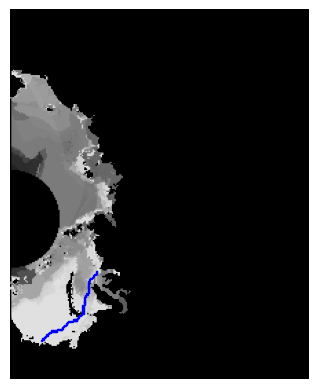

САРМАТ


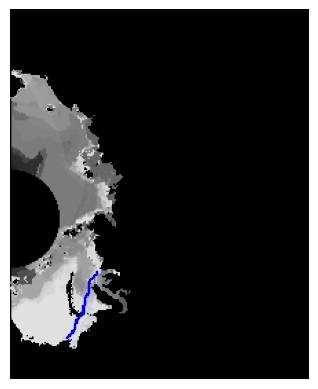

ШТУРМАН КОШЕЛЕВ


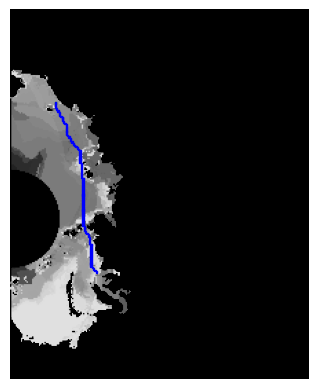

EDUARD TOLL


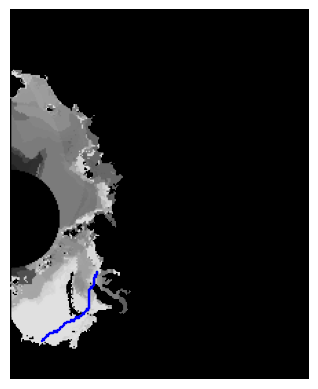

CHRISTOPHE DE MARGERIE


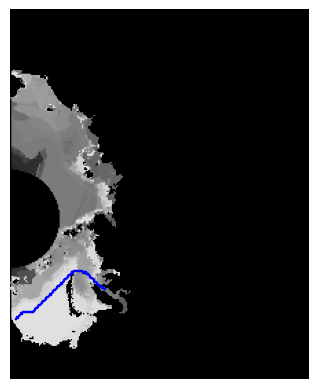

BORIS VILKITSKY


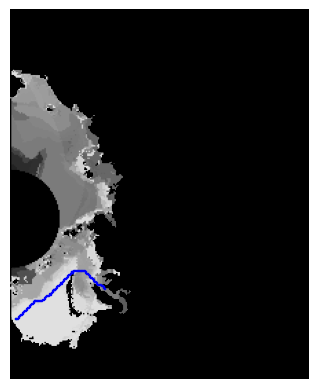

GEORGIY USHAKOV


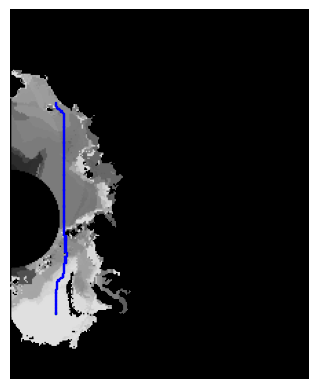

RUDOLF SAMOYLOVICH


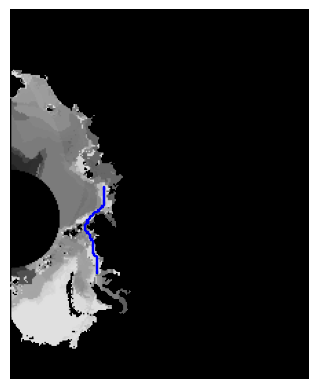

ИНЖЕНЕР ТРУБИН


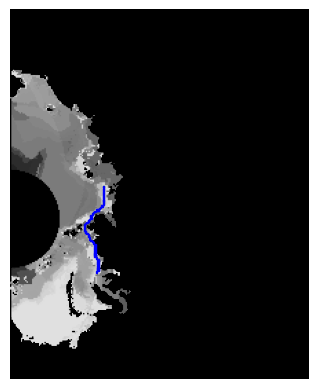

ИНЖЕНЕР ВЕШНЯКОВ


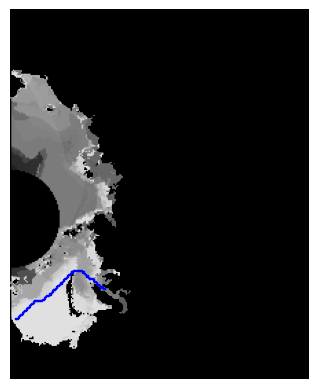

НИКИФОР БЕГИЧЕВ


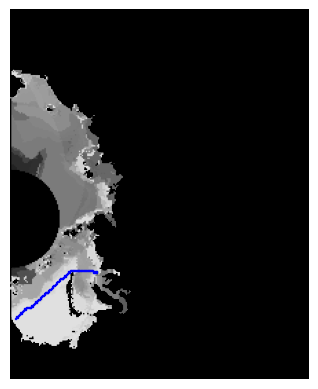

VLADIMIR VORONIN


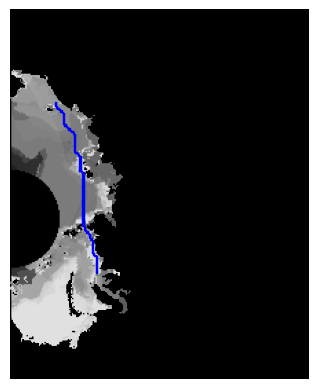

НОРИЛЬСКИЙ НИКЕЛЬ


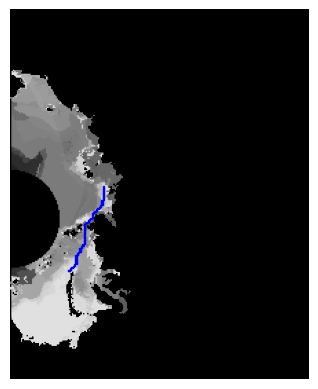

NIKOLAY YEVGENOV


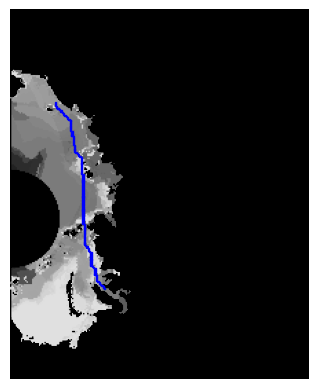

АРКТИКА-2


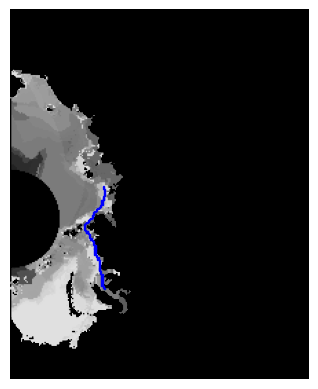

ПОЛАР КИНГ


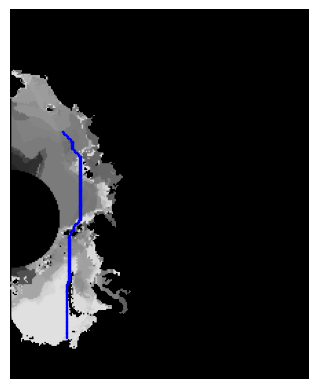

ТАМБЕЙ


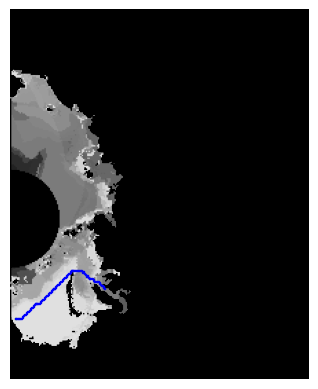

ИОГАНН МАХМАСТАЛЬ


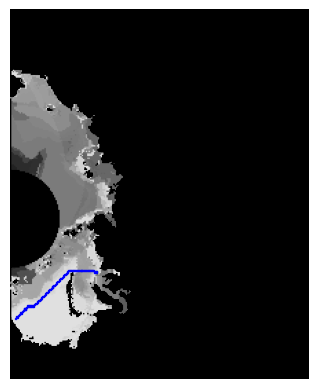

ШТУРМАН ЩЕРБИНИН


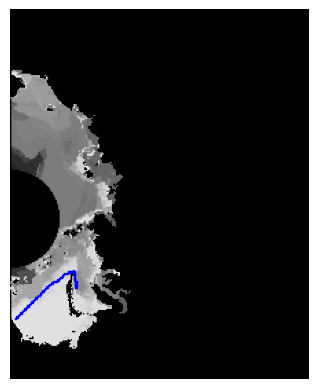

ШТУРМАН СКУРАТОВ


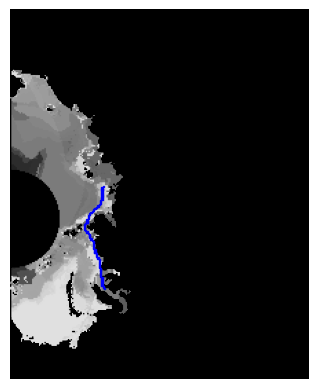

БАРЕНЦ


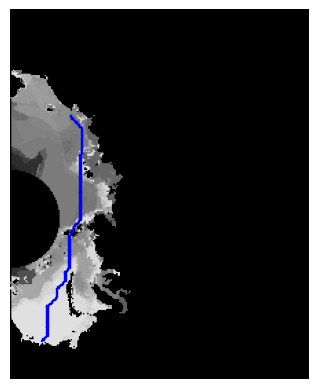

BORIS SOKOLOV


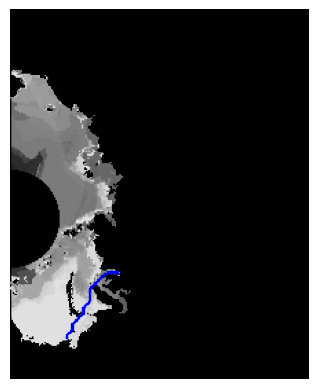

АЙС ИГЛ


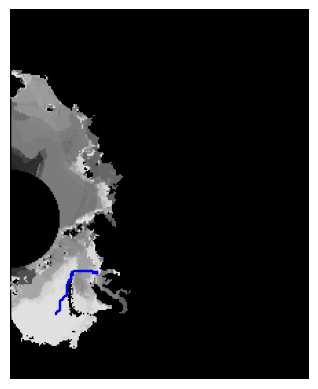

ШТУРМАН АЛЬБАНОВ


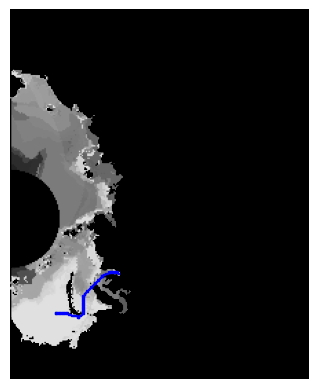

МЫС ДЕЖНЕВА


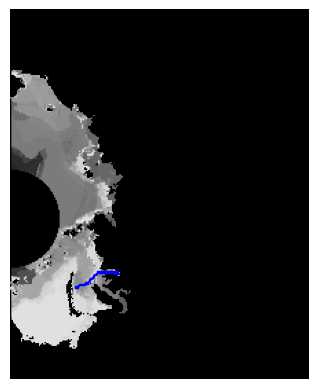

ГЕОРГИЙ УШАКОВ


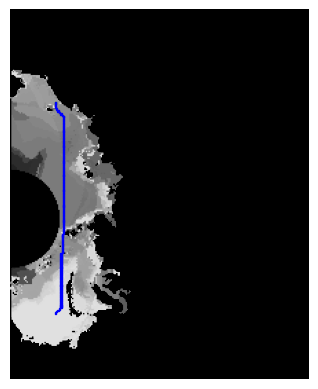

УРАРТУ


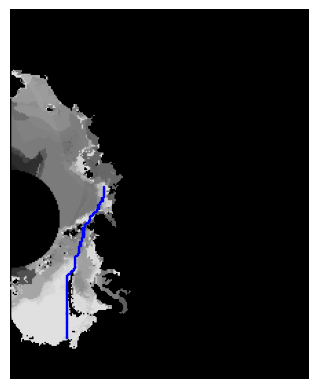

СЕВМОРПУТЬ


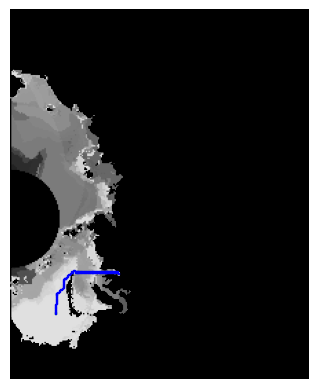

ГРИГОРИЙ ШЕЛИХОВ


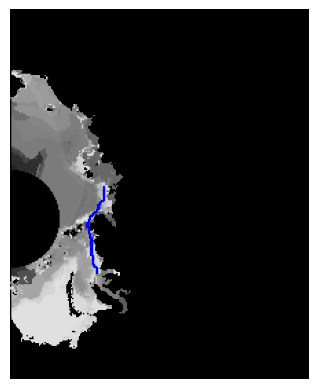

ФЕСКО ПАРИС


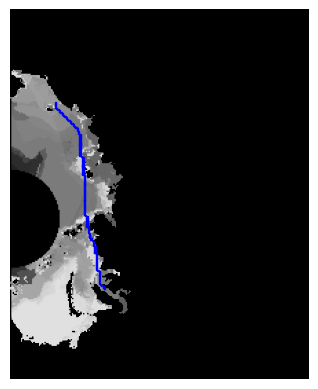

САБЕТТА


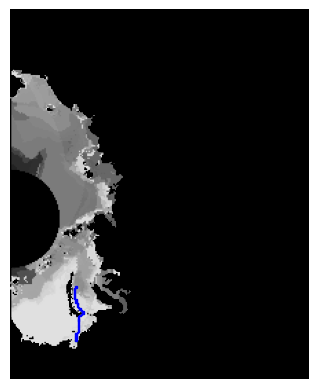

МИХАИЛ БРИТНЕВ


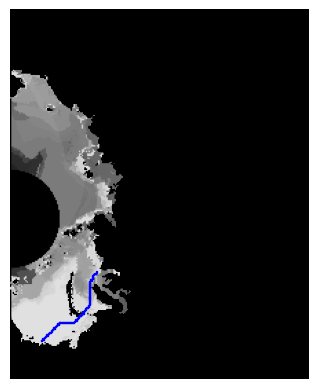

ПРОГРЕСС


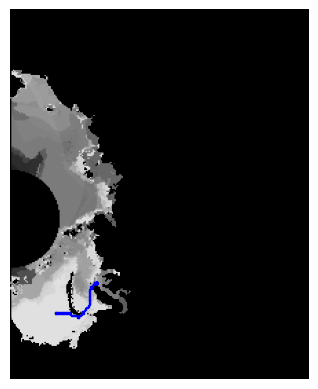

СЕВЕРНЫЙ ПРОЕКТ


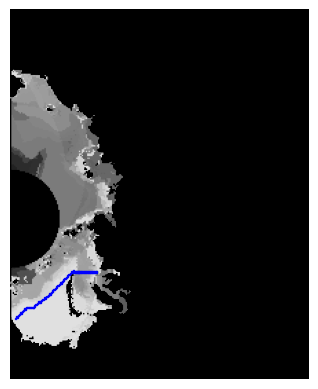

БЕРИНГ


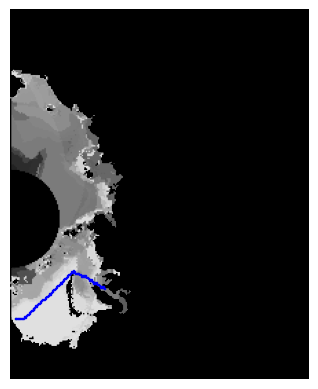

ТОЛБУХИН


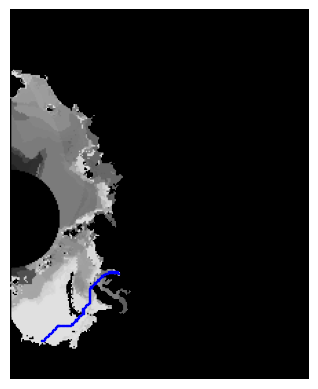

НИКОЛАЙ ЧУДОТВОРЕЦ


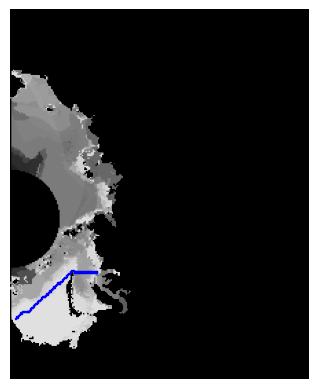

ТИКСИ


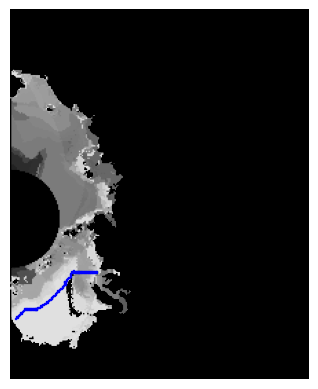

ЯМАЛ КРЕЧЕТ


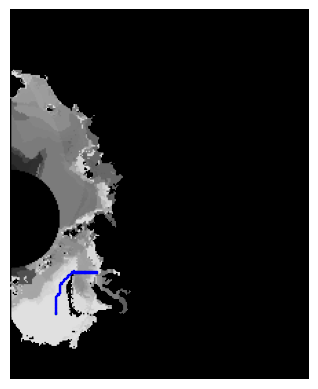

YAMAL SPIRIT


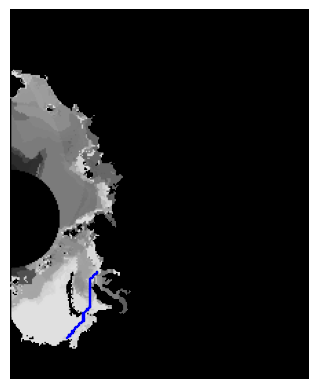

CLEAN VISION


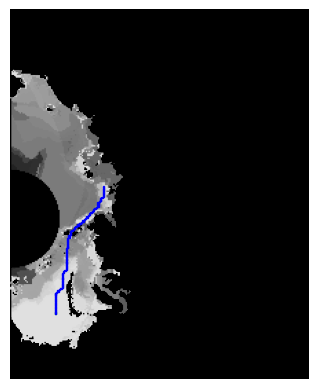

ТАЙБОЛА


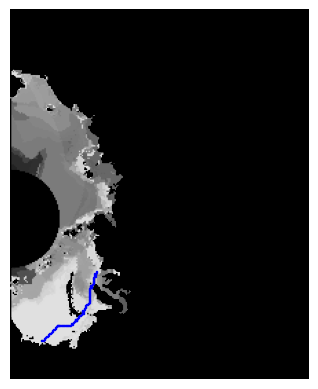

ТАЙБОЛА


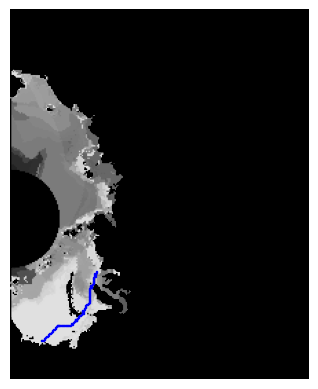

ТАЙБОЛА


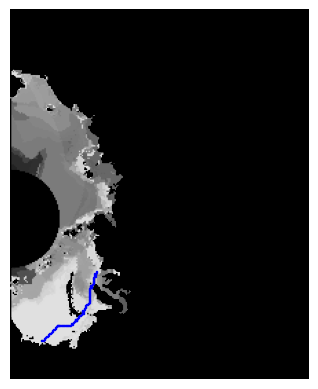

ТАЙБОЛА


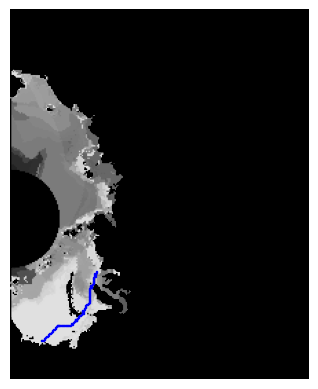

ТАЙБОЛА


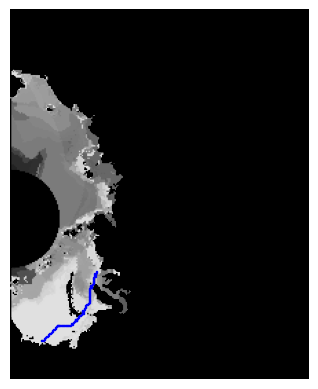

In [25]:
#Выводми графические изображения оптимальных маршрутов судов

for vessel in vessels_dbase:
    name = vessel['Название судна'] 
    print(name)
    path = vessel['Пройденный путь']
    matrix = ice_data_full['03-Mar-2020'] # Random matrix with values in range 0-30
    fig, ax = create_greyscale_matrix(matrix)

    # Define the route
    start_point = path[0]  # Starting point
    daily_moves = path  # Points visited in the daily moves
    planned_route = []    # Planned route points

    # Color the route on the matrix
    cell_width = 1  # Each cell is 1 unit wide
    cell_height = 1  # Each cell is 1 unit high
    ax = color_route_on_matrix(ax, cell_width, cell_height, start_point, daily_moves, planned_route)

    # Save and show the image
    plt.axis('off')
    plt.gca().invert_yaxis()
    plt.savefig(name+'matrix_colored_route.png', bbox_inches='tight')
    plt.show()